# Analiza cen nieruchomości w Sacramento

In [1]:
# Importing the libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import missingno as msno
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import colors

from scipy.stats import norm
from scipy import stats
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, cross_val_score

from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance


# Import Neural Network libraries
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# Opis zmiennych
d = {'Zmienna': ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude'],
     'Opis': ['Adres nieruchomości', 'Miasto', 'Kod pocztowy', 'Stan', 'Liczba pokoi', 'Liczba łazienek', 'Powierzchnia w stopach', 'Typ budynku- Rezydencja, Wielorodzinny, Condo', 'Data sprzedaży' , 'Cena', 'Szerekość geograficzna', 'Długość geograficzna']}
df = pd.DataFrame(data=d)
df

,Zmienna,Opis
0,street,Adres nieruchomości
1,city,Miasto
2,zip,Kod pocztowy
3,state,Stan
4,beds,Liczba pokoi
5,baths,Liczba łazienek
6,sq__ft,Powierzchnia w stopach
7,type,"Typ budynku- Rezydencja, Wielorodzinny, Condo"
8,sale_date,Data sprzedaży
9,price,Cena


## 1. Data exploration

In [3]:
# Wczytywanie danych 
df = pd.read_csv('Sacramento_real_estate_transactions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null object
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.4+ KB


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [4]:
#Opis zmiennej zależnej
df['price'].describe()

count       985.000000
mean     234144.263959
std      138365.839085
min        1551.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

In [5]:
print("Najbardziej skorelowane zmienne z ceną przed normalizacją i czyszczeniem danych")
corr = df.corr()
corr.sort_values(['price'], ascending=False, inplace=True)
corr.price

Najbardziej skorelowane zmienne z ceną przed normalizacją i czyszczeniem danych


price        1.000000
baths        0.416208
beds         0.342024
sq__ft       0.333897
longitude    0.284485
latitude    -0.039573
zip         -0.093353
Name: price, dtype: float64

In [6]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  5


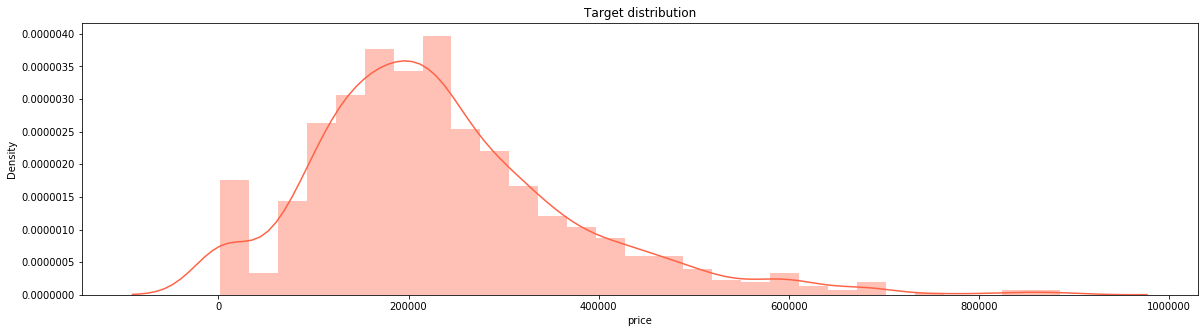

In [7]:
plt.figure(figsize=(20,5))
sns.distplot(df.price, color="tomato")
plt.title("Target distribution")
plt.ylabel("Density");

Rozkład zmiennej zależnej posiada asymetrie prawostronną

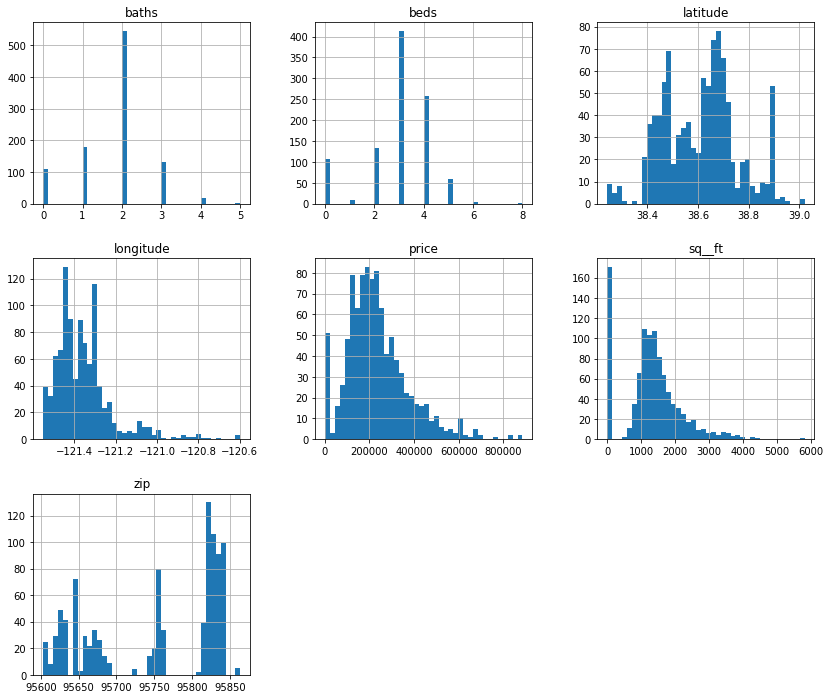

In [8]:
df.hist(bins=40, figsize=(14,12))
plt.show()

Obserwacje:

- zmienna 'sq__ft' posiada asymetrie prawostronną. W tym przypadku można zastąpić wszystkie zera medianą, jednak  większość z tych obserwacji ma także wartość 0 w innych kolumnach, zatem postanowiłem usunąć te wiersze.

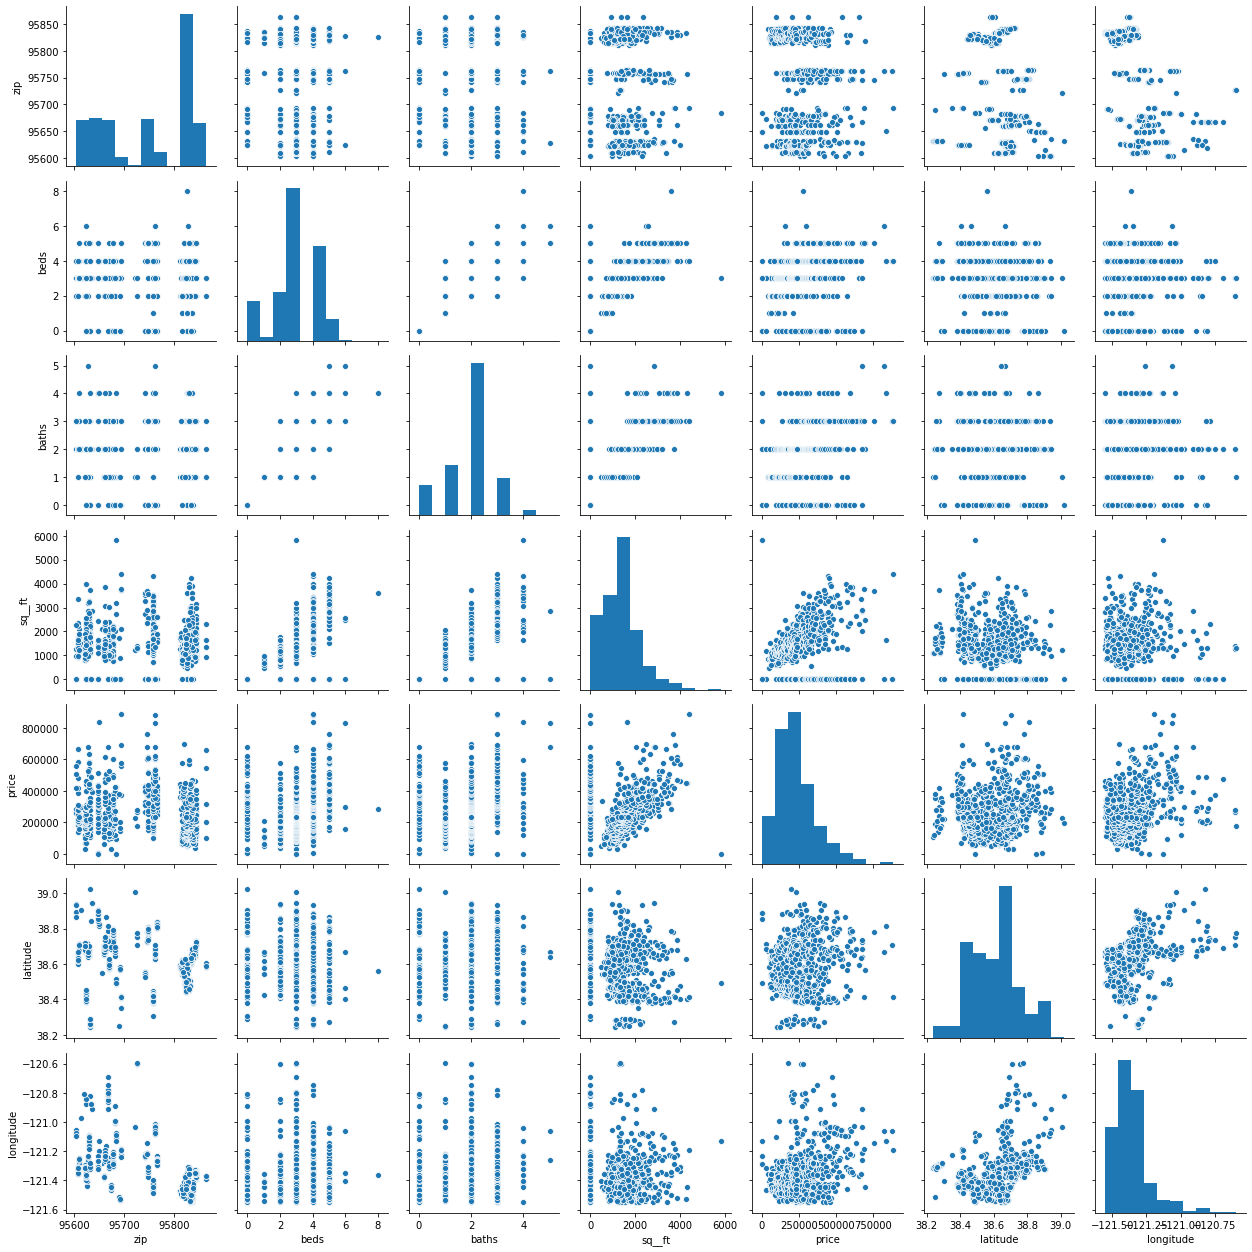

In [9]:
#Pairplots
%matplotlib inline
sns.pairplot(df, height=2.5)
plt.tight_layout()

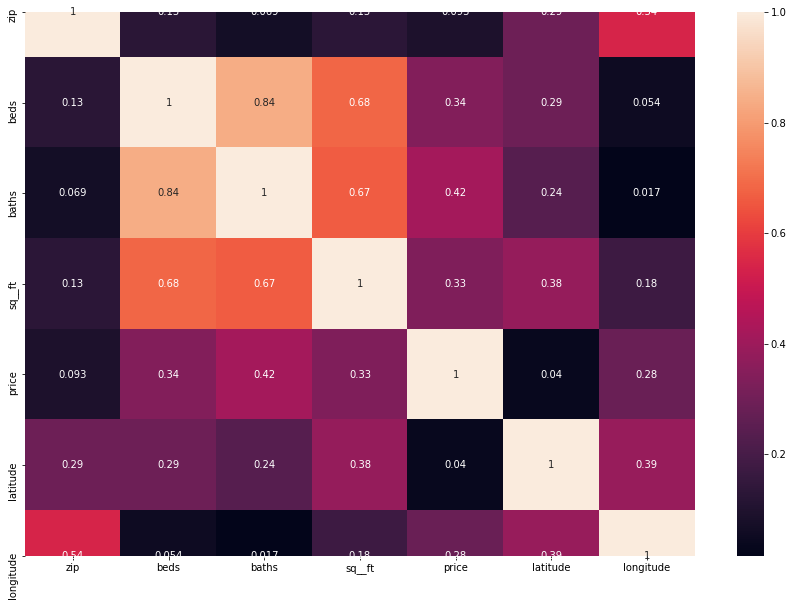

In [10]:
# Wykres korelacji Pearsona. 
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr().abs(),  annot=True)

Obserwacje:
- Jedyne zmienne, które są ze sobą silnie skorelowane to 'beds' oraz 'baths' jednak korelacja ta nie jest na tyle silna, aby odrzucać którąś z tych zmiennych. Później spróbuję stworzyć z tych dwóch zmiennych jedną zmienną - łączna liczba pomieszczeń. 



In [11]:
df.groupby('type').size()

type
Condo            54
Multi-Family     13
Residential     917
Unkown            1
dtype: int64

In [12]:
df[df['type'] == 'Condo'].mean()
# Dodać wykresy ze średnia ceną na metr na mieszkanie. Srednia pokoi, lazienek itp.

zip           95756.648148
beds              1.666667
baths             1.240741
sq__ft          760.425926
price        150082.185185
latitude         38.638827
longitude      -121.365441
dtype: float64

In [13]:
df[df['type'] == 'Multi-Family'].mean()

zip           95780.384615
beds              4.461538
baths             3.076923
sq__ft         2046.923077
price        224534.692308
latitude         38.597955
longitude      -121.352973
dtype: float64

In [14]:
df[df['type'] == 'Residential'].mean()

zip           95750.001091
beds              2.966194
baths             1.791712
sq__ft         1338.625954
price        239186.162486
latitude         38.606001
longitude      -121.355978
dtype: float64

Text(0.5, 1.0, 'price')

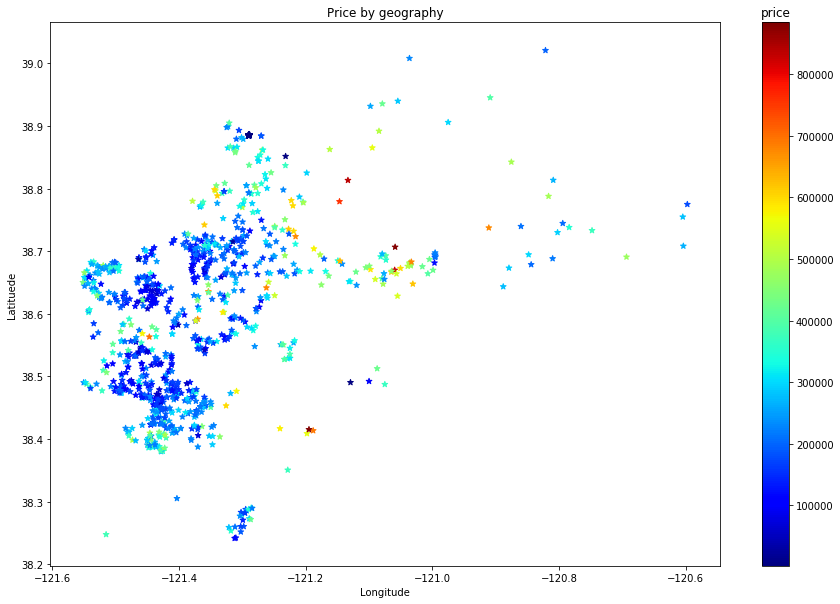

In [15]:
plt.figure(figsize=(15,10))
vmin = np.min(df.price)
vmax = np.max(df.price)
plt.scatter(df.longitude,df.latitude, marker='*',c=df.price,cmap='jet') 
plt.xlabel('Longitude')
plt.ylabel('Latituede')
plt.title('Price by geography')
clb = plt.colorbar() 
clb.ax.set_title('price')

## 2.Missing values and Data cleaning

In [16]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
longitude,0,0.0
latitude,0,0.0
price,0,0.0
sale_date,0,0.0
type,0,0.0


In [17]:
df['price'].describe()

count       985.000000
mean     234144.263959
std      138365.839085
min        1551.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

### 2.1 Outliers

In [18]:
df.loc[(df['price'] == 0)]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude


In [19]:
df['price'].loc[(df['price'] < 5000)].count()

51

In [20]:
df['price'].loc[(df['sq__ft'] == 0)].count()

171

In [21]:
# Usuwanie wszystkich wierszy w kolumnie 'sq__ft' w których wartość wynosi 0
df = df[df['sq__ft'] != 0]

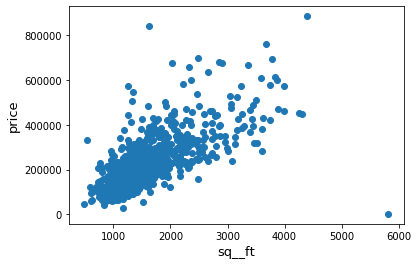

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = df['sq__ft'], y = df['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('sq__ft', fontsize=13)
plt.show()

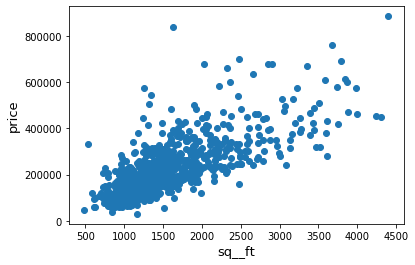

In [23]:
#Usuwanie obserwacji odstających
df = df.drop(df[(df['sq__ft']>5000) & (df['price']<800000)].index)

#Ponowne sprawdzenie
fig, ax = plt.subplots()
ax.scatter(df['sq__ft'], df['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('sq__ft', fontsize=13)
plt.show()

### 2.3 target normalization


 mu = 229728.13 and sigma = 119559.43



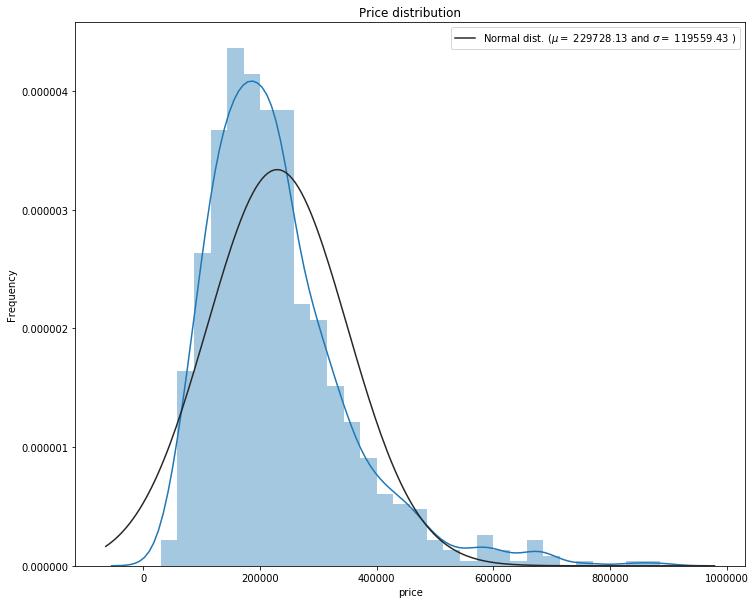

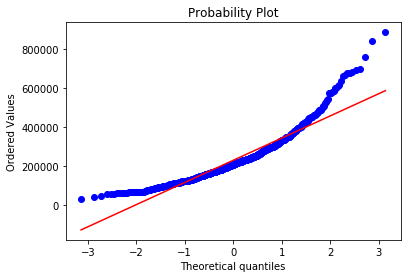

Skewness: 1.521667
Kurtosis: 3.610886


In [24]:
# Plot Histogram
plt.subplots(figsize=(12,10))
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())


Możemy zaobserwować, że zmienna docelowa:

- odbiega od rozkładu normalnego
- ma znacznie dodatnią skośność (prawostronna)
- Dane w modelach liniowych powinny mieć rozkład normalny, zmienimy te zmienną i sprawimy, że będzie miała rozkład bliski normalnemu.
- Modele drzewiaste powwinny poradzić sobie z tym problemem, jednak dla nich także zastosuje normalizacje zmiennej 'price'

In [25]:
#Użycie funkcji numpy 'log1p' w celu normalizacji zmiennej zależnej
df["price"] = np.log1p(df["price"])
#df["price"] = np.log(df["price"])


 mu = 12.22 and sigma = 0.50



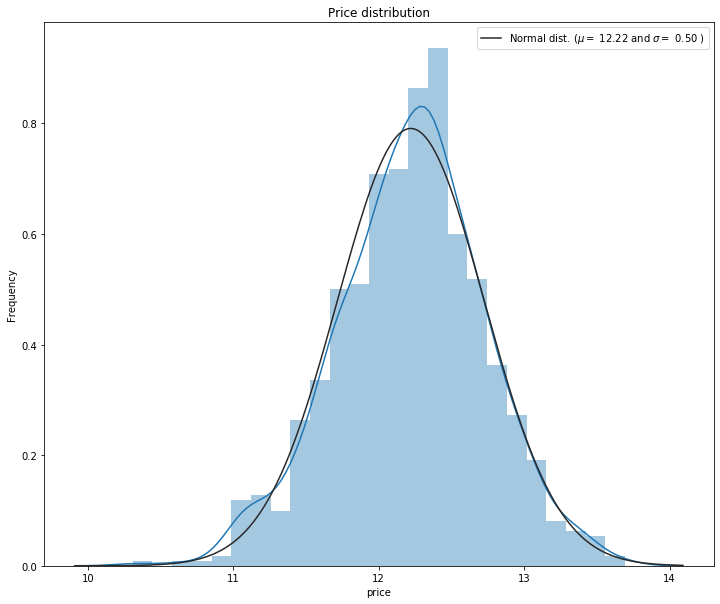

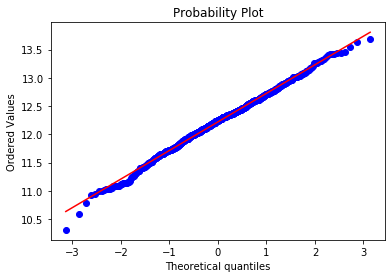

Skewness: -0.165897
Kurtosis: 0.220939


In [26]:
# Wyświetlenie histogramu po normalizacji
plt.subplots(figsize=(12,10))
sns.distplot(df['price'] , fit=norm);

(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

In [27]:
df = df.drop(columns=['state'])
df = df.drop(columns=['street'])
df = df.drop(columns=['sale_date'])

In [28]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  2


In [29]:
print('Numerical features - ',df[numerical_feats].columns)
print("*"*100)
print('Categorical features - ', df[categorical_feats].columns)

Numerical features -  Index(['zip', 'beds', 'baths', 'sq__ft', 'price', 'latitude', 'longitude'], dtype='object')
****************************************************************************************************
Categorical features -  Index(['city', 'type'], dtype='object')


In [30]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

SACRAMENTO         424
ELK GROVE          107
CITRUS HEIGHTS      35
ANTELOPE            33
ROSEVILLE           28
RANCHO CORDOVA      21
NORTH HIGHLANDS     21
CARMICHAEL          20
GALT                20
FOLSOM              15
RIO LINDA           12
ORANGEVALE          11
FAIR OAKS            9
ROCKLIN              8
LINCOLN              6
PLACERVILLE          5
WILTON               4
ELVERTA              4
GOLD RIVER           3
AUBURN               3
EL DORADO HILLS      3
GRANITE BAY          3
POLLOCK PINES        3
RANCHO MURIETA       2
LOOMIS               2
EL DORADO            2
PENRYN               1
GREENWOOD            1
WALNUT GROVE         1
MATHER               1
WEST SACRAMENTO      1
CAMERON PARK         1
DIAMOND SPRINGS      1
MEADOW VISTA         1
COOL                 1
Name: city, dtype: int64
##################################################
Residential     758
Condo            42
Multi-Family     13
Name: type, dtype: int64
##################################

In [31]:
#Czyszczenie danych w kolumnie city
df['city'] = df['city'].str.lower().str.replace('sacramentos', 'sacramento')
df['city'] = df['city'].str.lower().str.replace('west sacramento', 'sacramento')
df['city'] = df['city'].str.lower().str.replace('north highlands', 'antelope')

In [32]:
# Usunięcie miast, które pojawiły się nie częściej, niż 2 razy
N=2
df=df[df.groupby('city')['city'].transform('count')>N]

In [33]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

sacramento         425
elk grove          107
antelope            54
citrus heights      35
roseville           28
rancho cordova      21
galt                20
carmichael          20
folsom              15
rio linda           12
orangevale          11
fair oaks            9
rocklin              8
lincoln              6
placerville          5
elverta              4
wilton               4
auburn               3
el dorado hills      3
gold river           3
granite bay          3
pollock pines        3
Name: city, dtype: int64
##################################################
Residential     744
Condo            42
Multi-Family     13
Name: type, dtype: int64
##################################################


### 2.4 Data exploration after cleaning

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zip,799.0,95763.428035,84.846741,95603.000000,95670.000000,95820.000000,95829.000000,95864.000000
beds,799.0,3.245307,0.856875,1.000000,3.000000,3.000000,4.000000,8.000000
baths,799.0,1.957447,0.664677,1.000000,2.000000,2.000000,2.000000,5.000000
sq__ft,799.0,1581.794743,646.681626,484.000000,1142.000000,1416.000000,1843.500000,4400.000000
price,799.0,12.211464,0.502336,10.308986,11.899241,12.240479,12.542548,13.693107
latitude,799.0,38.574922,0.123498,38.241514,38.473225,38.589925,38.673245,38.939802
longitude,799.0,-121.384492,0.110391,-121.550527,-121.452021,-121.408288,-121.330587,-120.597599


In [35]:
#Tymczasowo przekształcam zmienne 'city' i 'type' na zmienne kategoryczne, aby sprawdzić korelacje.
temp_df = df.copy()

In [36]:
from sklearn.preprocessing import LabelEncoder
listToEncode = ['city', 'type']
temp_df[listToEncode] = temp_df[listToEncode].apply(LabelEncoder().fit_transform)

In [37]:
print("Najbardziej skorelowane zmienne z ceną po normalizacji i czyszczeniu danych")
corr = temp_df.corr()
corr.sort_values(['price'], ascending=False, inplace=True)
corr.price

Najbardziej skorelowane zmienne z ceną po normalizacji i czyszczeniu danych


price        1.000000
sq__ft       0.707764
baths        0.536891
beds         0.485291
longitude    0.249168
type         0.233044
latitude     0.020506
city        -0.198657
zip         -0.221432
Name: price, dtype: float64

Zmienna zip:
- http://www.city-data.com/zips/95838.html  << Statystyki dla przykładowego kodu poczetowego z naszego zestawu danych. Jak widzimy ze zmiennej tej można utworzyć wiele nowych zmiennych.

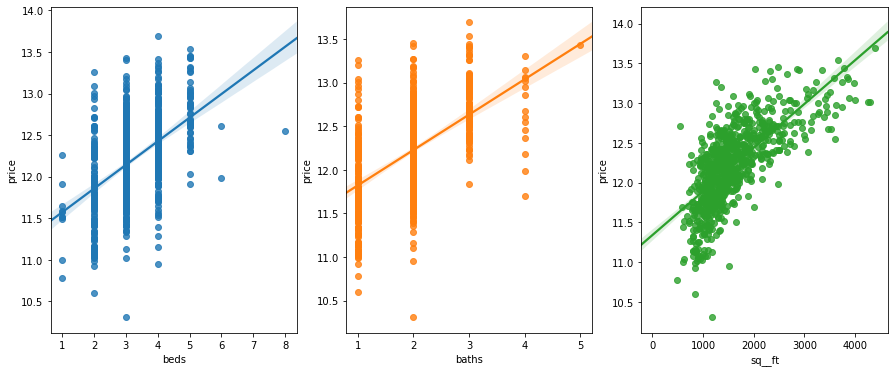

In [38]:
#Scatter Plots
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
beds_scatter_plot = pd.concat([df['price'],df['beds']],axis = 1)
sns.regplot(x='beds',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
beds_scatter_plot = pd.concat([df['price'],df['baths']],axis = 1)
sns.regplot(x='baths',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
beds_scatter_plot = pd.concat([df['price'],df['sq__ft']],axis = 1)
sns.regplot(x='sq__ft',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax3)


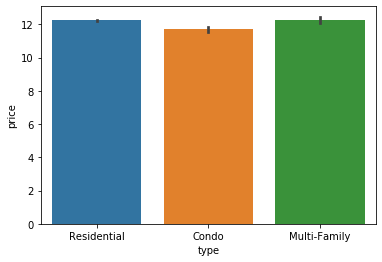

In [39]:
sns.barplot(df.type,df.price)

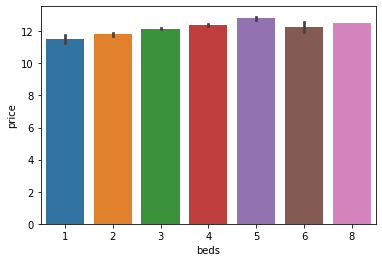

In [40]:
sns.barplot(df.beds,df.price)

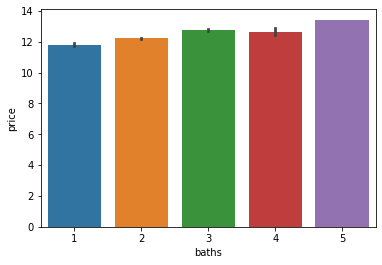

In [41]:
sns.barplot(df.baths,df.price)

In [42]:
# Straciliśmy około 10% danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 984
Data columns (total 9 columns):
city         799 non-null object
zip          799 non-null int64
beds         799 non-null int64
baths        799 non-null int64
sq__ft       799 non-null int64
type         799 non-null object
price        799 non-null float64
latitude     799 non-null float64
longitude    799 non-null float64
dtypes: float64(3), int64(4), object(2)
memory usage: 102.4+ KB


### 3 Modelling

In [43]:
lin_df = df.copy() #Kopia zostanie wykorzystana do modeli liniowych

In [44]:
dl_df = df.copy() #Kopia zostanie wykorzystana do modeli deep learningowych

In [45]:
df = pd.get_dummies(df, columns=["beds", "baths", "city", "type", 'zip'])

In [46]:
X = df.drop(["price"],axis=1)
y = df['price']

In [47]:
# Dzielenie danych za zestaw treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [48]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 3.1 Base models

##### XGBOOST

In [49]:
xgb1 = XGBRegressor()

In [56]:
parameters = {'learning_rate': [.1, .2, .3], 
              'min_child_weight':[4,5], 
              'gamma':[0, .1, .2, .3],
              'subsample':[.7, .8, .9, 1],
              'colsample_bytree':[.8, .9, 1], 
              'max_depth': [3, 4, 5, 6, 7], 
              'n_estimators': [100, 120, 200] }

In [57]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 6,
                        n_jobs = -1,
                        verbose=True)

In [58]:
xgb_grid.fit(X_train, y_train)

Fitting 6 folds for each of 4320 candidates, totalling 25920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

[03:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'gamma': [0, 0.1, 0.2, 0.3],
                         'learning_rate': [0.1, 0.2, 0.3],
           

In [59]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.6441534582073938
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.7}


In [49]:
# Fitting XGBoost to the Training set 
xgb_regressor = XGBRegressor(
    colsample_bytree= 0.8    
)

In [50]:
xgb_regressor.fit(X_train, y_train)

[04:14:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [51]:
# Predicting the Test set results
y_pred = xgb_regressor.predict(X_test)

In [52]:
score = xgb_regressor.score(X_test, y_test)
print(score*100)

64.62527315668625


In [53]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.21410768432359448
Mean Squared Error: 0.08203439698716858
Root Mean Squared Error: 0.2864164747132549


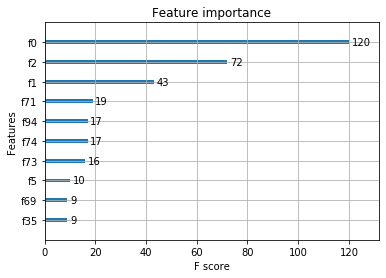

In [54]:
plot_importance(xgb_regressor, max_num_features=10) # top 10 most important features
plt.show()

In [55]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
pred_df= pd.DataFrame({'Real': y_test.flatten(), 'Pred': y_pred.flatten()})
pred_df.head(10)

,Real,Pred
0,12.367345,12.310925
1,12.031725,12.128840
2,11.970357,11.818712
3,11.931642,12.213892
4,12.644331,12.541426
5,12.598118,12.635054
6,12.485483,12.007585
7,12.415300,12.015204
8,12.037660,11.923599
9,12.036180,11.818150


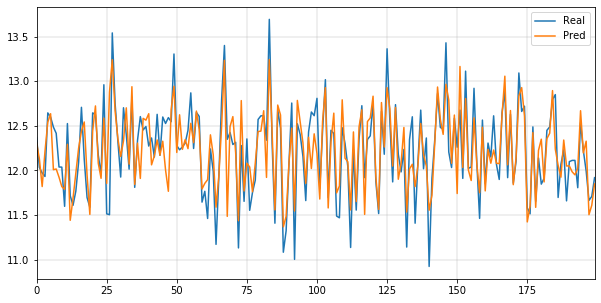

In [56]:
pred_df = pred_df.head(200)
pred_df.plot(kind='line',figsize=(10,5))
plt.grid(which='major',  linewidth='0.4')
plt.grid(which='minor', linewidth='0.4')
plt.show()

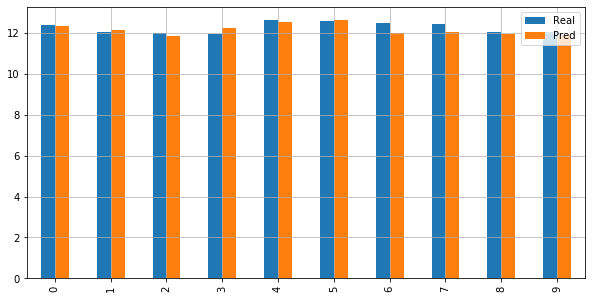

In [57]:
_pred_df = pred_df.head(10)
_pred_df.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linewidth='0.7')
plt.grid(which='minor', linewidth='0.7')
plt.show()

#### Linear regression
Dla modeli liniowych będziemy musieli zastosować także normalizacje zmiennej 'sq__ft' oraz zrezygnować z kilku ziennych 'Dummy'

Skewness: 1.495630
Kurtosis: 2.578352


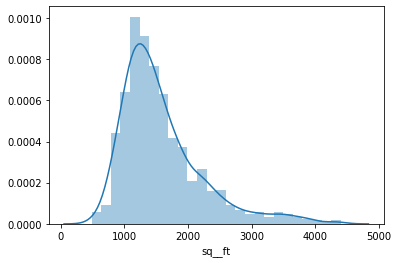

In [58]:
#
sns.distplot(lin_df['sq__ft']);
print("Skewness: %f" % lin_df['sq__ft'].skew())
print("Kurtosis: %f" % lin_df['sq__ft'].kurt())

In [59]:
lin_df['sq__ft_log'] = np.log(lin_df['sq__ft'])
lin_df.drop('sq__ft', inplace= True, axis = 1)

Skewness: 0.403701
Kurtosis: 0.133870


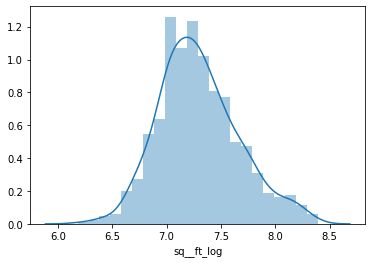

In [60]:
sns.distplot(lin_df['sq__ft_log']);
#skewness and kurtosis
print("Skewness: %f" % lin_df['sq__ft_log'].skew())
print("Kurtosis: %f" % lin_df['sq__ft_log'].kurt())

In [61]:
listToEncode = ['city', 'type',"beds", "baths"]
lin_df[listToEncode] = lin_df[listToEncode].apply(LabelEncoder().fit_transform)

In [62]:
X = lin_df.drop(["price"],axis=1)
y = lin_df['price']

In [63]:
# Dzielenie danych na zestaw testowy i treningowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [64]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [65]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [67]:
score = regressor.score(X_test, y_test)
print(score*100)

61.91153589732665


In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2296452549079714
Mean Squared Error: 0.088327584794363
Root Mean Squared Error: 0.29719957064969493


#### SVR

In [129]:
# Fitting SVR to the dataset
svr_regressor = SVR(
    kernel='linear',
    C=5,
    epsilon=0.05
    )
svr_regressor.fit(X_train, y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.05,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [130]:
# Predicting the Test set results
y_pred = svr_regressor.predict(X_test)

In [131]:
score = svr_regressor.score(X_test, y_test)
print(score*100)

62.25096575924254


In [132]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.22749265565208754
Mean Squared Error: 0.08754044305429978
Root Mean Squared Error: 0.2958723424963878


#### Neural network

In [133]:
dl_df.head()

,city,zip,beds,baths,sq__ft,type,price,latitude,longitude
0,sacramento,95838,2,1,836,Residential,10.989065,38.631913,-121.434879
1,sacramento,95823,3,1,1167,Residential,11.130390,38.478902,-121.431028
2,sacramento,95815,2,1,796,Residential,11.140136,38.618305,-121.443839
3,sacramento,95815,2,1,852,Residential,11.146316,38.616835,-121.439146
4,sacramento,95824,2,1,797,Residential,11.313266,38.519470,-121.435768


In [134]:
dl_df = pd.get_dummies(dl_df, columns=["beds", "baths", "city", "type", 'zip'])

In [140]:
X = dl_df.drop(["price"],axis=1)
y = dl_df['price']

In [141]:
# Dzielenie danych na zestaw testowy i treningowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [142]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [143]:
model=Sequential()
model.add(Dense(270,input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(120))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Dense(output_dim=1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='Adam', metrics =['mae'])
model.summary()
print(X_train.shape)
hist = model.fit(X_train,y_train,
          validation_split=.2,
          epochs=800,
          batch_size=20,
          verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 270)               25920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               32520     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

Epoch 50/800
415/415 [==============================] - 0s 110us/step - loss: 2.6375 - mae: 1.1998 - val_loss: 475.2149 - val_mae: 3.8528
Epoch 51/800
415/415 [==============================] - 0s 91us/step - loss: 2.8465 - mae: 1.2685 - val_loss: 472.9976 - val_mae: 3.7713
Epoch 52/800
415/415 [==============================] - 0s 89us/step - loss: 2.3710 - mae: 1.1618 - val_loss: 532.7675 - val_mae: 3.8182
Epoch 53/800
415/415 [==============================] - 0s 94us/step - loss: 2.9686 - mae: 1.2510 - val_loss: 533.2970 - val_mae: 3.7199
Epoch 54/800
415/415 [==============================] - 0s 92us/step - loss: 2.6523 - mae: 1.2264 - val_loss: 509.4813 - val_mae: 3.6865
Epoch 55/800
415/415 [==============================] - 0s 89us/step - loss: 2.6039 - mae: 1.2232 - val_loss: 472.0756 - val_mae: 3.6838
Epoch 56/800
415/415 [==============================] - 0s 94us/step - loss: 2.8948 - mae: 1.2048 - val_loss: 502.2041 - val_mae: 3.5842
Epoch 57/800
415/415 [==================

415/415 [==============================] - 0s 98us/step - loss: 1.8168 - mae: 0.9643 - val_loss: 388.3495 - val_mae: 3.1197
Epoch 110/800
415/415 [==============================] - 0s 100us/step - loss: 1.3212 - mae: 0.8892 - val_loss: 374.6510 - val_mae: 3.0107
Epoch 111/800
415/415 [==============================] - 0s 113us/step - loss: 1.4394 - mae: 0.9170 - val_loss: 346.7537 - val_mae: 3.0312
Epoch 112/800
415/415 [==============================] - 0s 106us/step - loss: 1.4647 - mae: 0.9276 - val_loss: 380.2275 - val_mae: 3.0791
Epoch 113/800
415/415 [==============================] - 0s 105us/step - loss: 1.6366 - mae: 0.9984 - val_loss: 372.2884 - val_mae: 3.0358
Epoch 114/800
415/415 [==============================] - 0s 106us/step - loss: 1.2643 - mae: 0.8749 - val_loss: 344.8704 - val_mae: 3.0061
Epoch 115/800
415/415 [==============================] - 0s 99us/step - loss: 1.1407 - mae: 0.8496 - val_loss: 373.8246 - val_mae: 3.1130
Epoch 116/800
415/415 [====================

415/415 [==============================] - 0s 100us/step - loss: 0.7995 - mae: 0.6949 - val_loss: 177.3161 - val_mae: 2.1378
Epoch 169/800
415/415 [==============================] - 0s 99us/step - loss: 0.9535 - mae: 0.7739 - val_loss: 169.5415 - val_mae: 2.1142
Epoch 170/800
415/415 [==============================] - 0s 104us/step - loss: 0.7995 - mae: 0.7134 - val_loss: 160.8332 - val_mae: 2.0839
Epoch 171/800
415/415 [==============================] - 0s 100us/step - loss: 0.8329 - mae: 0.7018 - val_loss: 183.6916 - val_mae: 2.2836
Epoch 172/800
415/415 [==============================] - 0s 100us/step - loss: 0.9654 - mae: 0.8139 - val_loss: 174.0112 - val_mae: 2.1997
Epoch 173/800
415/415 [==============================] - 0s 92us/step - loss: 0.8899 - mae: 0.7306 - val_loss: 147.3420 - val_mae: 2.0963
Epoch 174/800
415/415 [==============================] - 0s 90us/step - loss: 0.8671 - mae: 0.7181 - val_loss: 158.5044 - val_mae: 2.0613
Epoch 175/800
415/415 [=====================

415/415 [==============================] - 0s 103us/step - loss: 0.5162 - mae: 0.5548 - val_loss: 44.2036 - val_mae: 1.2406
Epoch 228/800
415/415 [==============================] - 0s 97us/step - loss: 0.6073 - mae: 0.6040 - val_loss: 41.8480 - val_mae: 1.1908
Epoch 229/800
415/415 [==============================] - 0s 104us/step - loss: 0.5282 - mae: 0.5650 - val_loss: 46.4471 - val_mae: 1.3288
Epoch 230/800
415/415 [==============================] - 0s 109us/step - loss: 0.5031 - mae: 0.5790 - val_loss: 42.6869 - val_mae: 1.2394
Epoch 231/800
415/415 [==============================] - 0s 106us/step - loss: 0.5044 - mae: 0.5690 - val_loss: 36.1314 - val_mae: 1.1431
Epoch 232/800
415/415 [==============================] - 0s 140us/step - loss: 0.5277 - mae: 0.5823 - val_loss: 35.5069 - val_mae: 1.1258
Epoch 233/800
415/415 [==============================] - 0s 110us/step - loss: 0.4803 - mae: 0.5395 - val_loss: 40.8702 - val_mae: 1.2562
Epoch 234/800
415/415 [==========================

Epoch 287/800
415/415 [==============================] - 0s 98us/step - loss: 0.3539 - mae: 0.4780 - val_loss: 6.1711 - val_mae: 0.6429
Epoch 288/800
415/415 [==============================] - 0s 99us/step - loss: 0.3395 - mae: 0.4593 - val_loss: 6.6494 - val_mae: 0.6467
Epoch 289/800
415/415 [==============================] - 0s 106us/step - loss: 0.3086 - mae: 0.4213 - val_loss: 7.6046 - val_mae: 0.7139
Epoch 290/800
415/415 [==============================] - 0s 105us/step - loss: 0.3441 - mae: 0.4690 - val_loss: 5.4666 - val_mae: 0.5940
Epoch 291/800
415/415 [==============================] - 0s 104us/step - loss: 0.3482 - mae: 0.4694 - val_loss: 5.1589 - val_mae: 0.5996
Epoch 292/800
415/415 [==============================] - 0s 104us/step - loss: 0.3342 - mae: 0.4272 - val_loss: 5.9606 - val_mae: 0.6152
Epoch 293/800
415/415 [==============================] - 0s 100us/step - loss: 0.3164 - mae: 0.4336 - val_loss: 6.8296 - val_mae: 0.6855
Epoch 294/800
415/415 [====================

Epoch 347/800
415/415 [==============================] - 0s 92us/step - loss: 0.2285 - mae: 0.3751 - val_loss: 0.9320 - val_mae: 0.3989
Epoch 348/800
415/415 [==============================] - 0s 97us/step - loss: 0.2155 - mae: 0.3656 - val_loss: 1.1510 - val_mae: 0.4269
Epoch 349/800
415/415 [==============================] - 0s 140us/step - loss: 0.2431 - mae: 0.3957 - val_loss: 0.9315 - val_mae: 0.3835
Epoch 350/800
415/415 [==============================] - 0s 96us/step - loss: 0.2370 - mae: 0.3758 - val_loss: 1.0266 - val_mae: 0.4000
Epoch 351/800
415/415 [==============================] - 0s 100us/step - loss: 0.2088 - mae: 0.3644 - val_loss: 0.9650 - val_mae: 0.3829
Epoch 352/800
415/415 [==============================] - 0s 97us/step - loss: 0.2654 - mae: 0.3926 - val_loss: 1.1726 - val_mae: 0.4196
Epoch 353/800
415/415 [==============================] - 0s 98us/step - loss: 0.2030 - mae: 0.3498 - val_loss: 0.9255 - val_mae: 0.3801
Epoch 354/800
415/415 [=======================

415/415 [==============================] - 0s 92us/step - loss: 0.1538 - mae: 0.3053 - val_loss: 0.2796 - val_mae: 0.3126
Epoch 408/800
415/415 [==============================] - 0s 91us/step - loss: 0.1670 - mae: 0.3298 - val_loss: 0.4423 - val_mae: 0.3429
Epoch 409/800
415/415 [==============================] - 0s 93us/step - loss: 0.1508 - mae: 0.3000 - val_loss: 0.4721 - val_mae: 0.3504
Epoch 410/800
415/415 [==============================] - 0s 96us/step - loss: 0.1631 - mae: 0.3138 - val_loss: 0.4158 - val_mae: 0.3493
Epoch 411/800
415/415 [==============================] - 0s 91us/step - loss: 0.1274 - mae: 0.2705 - val_loss: 0.3701 - val_mae: 0.3252
Epoch 412/800
415/415 [==============================] - 0s 93us/step - loss: 0.1585 - mae: 0.3102 - val_loss: 0.3297 - val_mae: 0.3186
Epoch 413/800
415/415 [==============================] - 0s 94us/step - loss: 0.1471 - mae: 0.2942 - val_loss: 0.3223 - val_mae: 0.3168
Epoch 414/800
415/415 [==============================] - 0s 95

415/415 [==============================] - 0s 109us/step - loss: 0.0970 - mae: 0.2441 - val_loss: 0.1785 - val_mae: 0.2964
Epoch 468/800
415/415 [==============================] - 0s 102us/step - loss: 0.0958 - mae: 0.2386 - val_loss: 0.1667 - val_mae: 0.2948
Epoch 469/800
415/415 [==============================] - 0s 120us/step - loss: 0.1057 - mae: 0.2444 - val_loss: 0.1678 - val_mae: 0.2870
Epoch 470/800
415/415 [==============================] - 0s 114us/step - loss: 0.1050 - mae: 0.2506 - val_loss: 0.2105 - val_mae: 0.2983
Epoch 471/800
415/415 [==============================] - 0s 103us/step - loss: 0.1063 - mae: 0.2521 - val_loss: 0.2273 - val_mae: 0.3019
Epoch 472/800
415/415 [==============================] - 0s 145us/step - loss: 0.1015 - mae: 0.2463 - val_loss: 0.2313 - val_mae: 0.2965
Epoch 473/800
415/415 [==============================] - 0s 141us/step - loss: 0.1163 - mae: 0.2627 - val_loss: 0.2211 - val_mae: 0.3155
Epoch 474/800
415/415 [==============================] 

415/415 [==============================] - 0s 102us/step - loss: 0.0811 - mae: 0.2131 - val_loss: 0.1260 - val_mae: 0.2563
Epoch 528/800
415/415 [==============================] - 0s 100us/step - loss: 0.0811 - mae: 0.2173 - val_loss: 0.1496 - val_mae: 0.2658
Epoch 529/800
415/415 [==============================] - 0s 95us/step - loss: 0.0789 - mae: 0.2078 - val_loss: 0.1362 - val_mae: 0.2702
Epoch 530/800
415/415 [==============================] - 0s 98us/step - loss: 0.0797 - mae: 0.2166 - val_loss: 0.1436 - val_mae: 0.2766
Epoch 531/800
415/415 [==============================] - 0s 103us/step - loss: 0.0817 - mae: 0.2173 - val_loss: 0.1402 - val_mae: 0.2658
Epoch 532/800
415/415 [==============================] - 0s 96us/step - loss: 0.0764 - mae: 0.2099 - val_loss: 0.1452 - val_mae: 0.2776
Epoch 533/800
415/415 [==============================] - 0s 95us/step - loss: 0.0858 - mae: 0.2213 - val_loss: 0.1491 - val_mae: 0.2860
Epoch 534/800
415/415 [==============================] - 0s

415/415 [==============================] - 0s 100us/step - loss: 0.0881 - mae: 0.2267 - val_loss: 0.1734 - val_mae: 0.2839
Epoch 588/800
415/415 [==============================] - 0s 98us/step - loss: 0.0778 - mae: 0.2104 - val_loss: 0.1982 - val_mae: 0.2897
Epoch 589/800
415/415 [==============================] - 0s 96us/step - loss: 0.0817 - mae: 0.2158 - val_loss: 0.2272 - val_mae: 0.3194
Epoch 590/800
415/415 [==============================] - 0s 97us/step - loss: 0.0772 - mae: 0.2059 - val_loss: 0.1504 - val_mae: 0.2752
Epoch 591/800
415/415 [==============================] - 0s 99us/step - loss: 0.0763 - mae: 0.2067 - val_loss: 0.1424 - val_mae: 0.2682
Epoch 592/800
415/415 [==============================] - 0s 100us/step - loss: 0.0778 - mae: 0.2046 - val_loss: 0.1834 - val_mae: 0.2849
Epoch 593/800
415/415 [==============================] - 0s 98us/step - loss: 0.0790 - mae: 0.2126 - val_loss: 0.1593 - val_mae: 0.2836
Epoch 594/800
415/415 [==============================] - 0s 

415/415 [==============================] - 0s 93us/step - loss: 0.0794 - mae: 0.2078 - val_loss: 0.1741 - val_mae: 0.2869
Epoch 648/800
415/415 [==============================] - 0s 91us/step - loss: 0.0769 - mae: 0.2074 - val_loss: 0.1367 - val_mae: 0.2663
Epoch 649/800
415/415 [==============================] - 0s 91us/step - loss: 0.0768 - mae: 0.2086 - val_loss: 0.1369 - val_mae: 0.2684
Epoch 650/800
415/415 [==============================] - 0s 110us/step - loss: 0.0792 - mae: 0.2113 - val_loss: 0.1236 - val_mae: 0.2502
Epoch 651/800
415/415 [==============================] - 0s 99us/step - loss: 0.0780 - mae: 0.2092 - val_loss: 0.1283 - val_mae: 0.2583
Epoch 652/800
415/415 [==============================] - 0s 112us/step - loss: 0.0773 - mae: 0.2114 - val_loss: 0.1522 - val_mae: 0.2738
Epoch 653/800
415/415 [==============================] - 0s 116us/step - loss: 0.0740 - mae: 0.2045 - val_loss: 0.1919 - val_mae: 0.3041
Epoch 654/800
415/415 [==============================] - 0s

415/415 [==============================] - 0s 92us/step - loss: 0.0838 - mae: 0.2211 - val_loss: 0.1517 - val_mae: 0.2793
Epoch 708/800
415/415 [==============================] - 0s 93us/step - loss: 0.0860 - mae: 0.2189 - val_loss: 0.1272 - val_mae: 0.2615
Epoch 709/800
415/415 [==============================] - 0s 92us/step - loss: 0.0809 - mae: 0.2174 - val_loss: 0.1480 - val_mae: 0.2718
Epoch 710/800
415/415 [==============================] - 0s 93us/step - loss: 0.0868 - mae: 0.2200 - val_loss: 0.1609 - val_mae: 0.2813
Epoch 711/800
415/415 [==============================] - 0s 93us/step - loss: 0.0819 - mae: 0.2094 - val_loss: 0.1553 - val_mae: 0.2818
Epoch 712/800
415/415 [==============================] - 0s 91us/step - loss: 0.0815 - mae: 0.2136 - val_loss: 0.1392 - val_mae: 0.2694
Epoch 713/800
415/415 [==============================] - 0s 92us/step - loss: 0.0761 - mae: 0.2032 - val_loss: 0.1955 - val_mae: 0.2890
Epoch 714/800
415/415 [==============================] - 0s 97

415/415 [==============================] - 0s 91us/step - loss: 0.0834 - mae: 0.2187 - val_loss: 0.1411 - val_mae: 0.2692
Epoch 768/800
415/415 [==============================] - 0s 89us/step - loss: 0.0777 - mae: 0.2080 - val_loss: 0.1242 - val_mae: 0.2567
Epoch 769/800
415/415 [==============================] - 0s 92us/step - loss: 0.0835 - mae: 0.2145 - val_loss: 0.1466 - val_mae: 0.2685
Epoch 770/800
415/415 [==============================] - 0s 93us/step - loss: 0.0805 - mae: 0.2131 - val_loss: 0.1549 - val_mae: 0.2820
Epoch 771/800
415/415 [==============================] - 0s 90us/step - loss: 0.0819 - mae: 0.2138 - val_loss: 0.2296 - val_mae: 0.3131
Epoch 772/800
415/415 [==============================] - 0s 93us/step - loss: 0.0824 - mae: 0.2158 - val_loss: 0.1471 - val_mae: 0.2772
Epoch 773/800
415/415 [==============================] - 0s 92us/step - loss: 0.0809 - mae: 0.2140 - val_loss: 0.1185 - val_mae: 0.2514
Epoch 774/800
415/415 [==============================] - 0s 89

In [144]:
result = model.evaluate(X_test, y_test, verbose=0)
result

[0.08809264749288559, 0.21922695636749268]

In [145]:
model.evaluate(X_test, y_test)[1]

280/280 [==============================] - 0s 23us/step


0.21922695636749268

In [146]:
hist.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

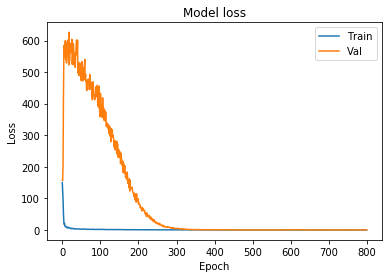

In [147]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 4. Wnioski

- Model XGBOOST osiągnął najmniejszy błąd średniokwadratowy zajmując tym samym pierwsze miejsce.

- Po normalizacji zmiennej "sq__ft" modele liniowe (regresja liniowa, liniowy SVR) wypadły niewiele gorzej. Jeśli zależałoby mi na prostym modelu to wybrałbym regresje liniową. 

- Wynik sieci neuronowej nie jest najlepszy. myślę, że model działa źle, ponieważ mamy dość mały zestaw danych. Sieć neuronowa działa najlepiej na dużych zbiorach danych.

Pozostałe sprawdzane modele - lasso, ridge, random forest wypadły podobnie.